Disponemos de un dataset con información de inmuebles vendidos en el Condado de King, incluida la ciudad de Seattle, entre mayo de 2014 y mayo de 2015.

El objetivo de la práctica consiste en utilizar dos de los algoritmos vistos en el módulo para la estimación de los precios de venta de inmuebles en este condado y para esas fechas.

Las variables son las siguientes: 

- Id: identificador del inmueble. (eliminada)
- Date: fecha de venta en formato “YYYYMMDDT000000”. (transformada) 
- Price: precio de venta final en $. (transformada log)
- Bedrooms: número de habitaciones del inmueble. (queda)
- Bathrooms: número de aseos del inmueble. (transformada a entera)
- Sqft_living: área del inmueble en pies cuadrados. (conversión)
- Sqft_lot: área de la parcela en la que se encuentra. (conversión)
- Floors: número de pisos del inmueble. (queda)
- Waterfront: valor = 0 si no tiene vistas al mar; valor = 1 si tiene vistas al mar. (queda)
- View: nos dice si ha sido visitada por potenciales compradores muchas o pocas veces (0 pocas, 4 muchas). (categórica transformada)  
- Condition: condición en la que se encuentra el inmueble (1 mal, 5 muy bien). (categórica transformada) 
- Grade: calificación dada al inmueble, basada en un sistema propio del Condado de King (cuanto mayor es el valor, mejor es el inmueble). 
- Sqft_above: área en pies cuadrados del inmueble si no contamos el sótano. 
- Sqft_basement: área en pies cuadrados del sótano. 
- Yr_built: año de construcción. 
- Yr_renovated: año en que fue reformado/restaurado. 
- Zipcode: parecido al código postal español. (eliminada) 
- Lat: latitud en grados. (eliminada)
- Lon: longitud en grados. (eliminada)
- Sqft_living: área media de los 15 inmuebles vecinos más cercanos. 
- Sqft_lot15: área media de las 15 parcelas vecinas más cercanas. 

Con todos estos datos os pedimos lo siguiente: 
1. Preprocesado: 
  - Convertir las áreas a metros cuadrados. 
  - Convertir la fecha de venta en string “YYYYMMDD”. 
2. Estimación de precios: 
  - Utilizar el algoritmo de Árboles de Decisión. 
  - Utilizar el algoritmo de Random Forest. 
  - Utilizar el algoritmo de Grandient Boodting.
3. Evaluación de los modelos: 
  - Comparar los valores de R2 de ambos modelos. 
  - Comentar los resultados. 

***Consideraciones:***
Los resultados de R2 pueden ser dispares entre grupos. No hay un modelo único correcto. 
En cuanto a los dos algoritmos, pedimos que probéis diferentes parametrizaciones buscando modelos que generalicen correctamente (evitar over y underfitting).


# Setup 

In [2]:

import pandas as pd 
import numpy as np 
import pprint 
import csv
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
from google.colab import files
from matplotlib import rcParams
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score,confusion_matrix, precision_recall_curve, classification_report, plot_roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from matplotlib.colors import ListedColormap

In [4]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving act4_kc_house_data.csv to act4_kc_house_data.csv
User uploaded file "act4_kc_house_data.csv" with length 2515206 bytes


# Pre processing

In [5]:
path = "/content/act4_kc_house_data.csv"
df = pd.read_csv(path, sep=',')

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Convertimos las columnas de *square feet* to *square meters* multiplicando cada valor de las columnas sqft por el valor de conversión que es 0.92903, así obtenemos la conversión y además le cambiamos el nombre de la variable en donde m_ indica ***meters***

In [7]:
# Creamos las variables
columns_sqft = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
rename_columns= {'sqft_living': 'm_living',
                 'sqft_lot':'m_lot',
                 'sqft_above': 'm_above',
                'sqft_basement':'m_basement',
                 'sqft_living15':'m_living15',
                 'sqft_lot15':'m_lot15'}

# Loop para convertir el valor de square feet to square meter
for column in columns_sqft:
  df[column] = df[column] * 0.092903

# Cambio de nombre a las columnas
df.rename(columns= rename_columns, inplace=True, errors='raise')

En el pre procesado de los datos se nos pide cambiar la variable date a string en el siguiente block code podemos observar como se aplica la conversión de la columna. No obstante para mí criterio de modelización sería mejor trabajar con las columnas de las fechas separadas para mayor profundidad de trabajo de los datos por años, meses e incluso días. 

In [8]:

# Creamos las variables year month day 
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Almacenamos 
df_train3 = pd.DataFrame({"year":df['date'].dt.year, "month": df["date"].dt.month, "day":df["date"].dt.dayofyear})

# Drop date
df.drop('date', axis = 1, inplace = True)


In [10]:
df_train3.head()

,year,month,day
0,2014,10,286
1,2014,12,343
2,2015,2,56
3,2014,12,343
4,2015,2,49


Encontramos algunos datos interesantes.

 - la variable *bathrooms* es float, no podemos tener 2.5 baños o 0.75 baños.
 - Las casas tienen por promedio 3 habitaciones y 2 baños 
 - Las casas en promedio fueron construidas en 1971 
 - La condición de las casas se encuentra en promedio en 3, es decir, regular.
 - el 95% de las casas no han sido renovadas.
 - También observe que float era float lo converti a integer para su categorización.

Estos datos previo a realizar nos permite conocerer la categorización de las variables, como se comportan algunas y como mejorar su estructura para encontrar un mejor modelo. 

Solución:
  - redondeamos los registros de la columna ***bathrooms*** en nuestro dataframe.
  - Como el 95% de los datos de la variable ***yr_renovated*** son 0 ya que no han renovado sus hogares decidi eliminar la variable por un nivel alto de carnalidad, por lo tanto referira posibles problemas como en la dimensión de los datos o predictibilidad. 

In [11]:
df["bathrooms"] = df['bathrooms'].round(0).astype(int)

print("Freuency bathroom description:")
print(df["bathrooms"].value_counts())


Freuency bathroom description:
2    13851
1     3933
3     2527
4     1201
5       57
6       24
0       14
8        4
7        2
Name: bathrooms, dtype: int64


In [12]:
df['m_basement'].value_counts() 

0.000000     13126
55.741800      221
65.032100      218
46.451500      214
74.322400      206
             ...  
48.123754        1
34.745722        1
72.835952        1
84.170118        1
23.039944        1
Name: m_basement, Length: 306, dtype: int64

In [13]:
df.floors = df.floors.astype(int)

Algunos gráficos para interpretar mejor los datos de ciertas variables.

conocemos la distribucion de la variable independiente.

- La distribución se encuentrta entre 0 y 3. Es decir que los precios van desde \$0.00 hasta \$300,000.00

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


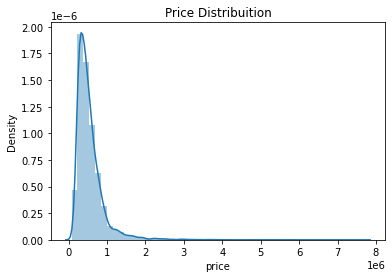

In [14]:
plt.title('Price Distribuition')
sns.distplot(df["price"])

plt.show()

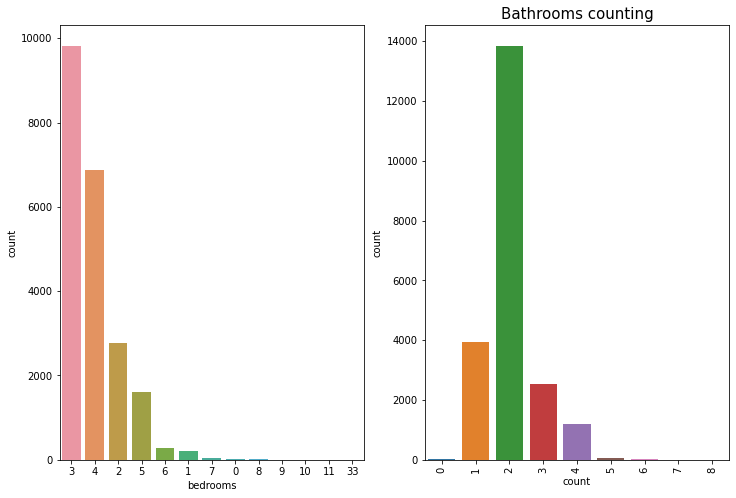

In [16]:
plt.figure(figsize = (12, 8))
ax1 = plt.subplot(121)
sns.countplot(x= "bedrooms" ,data=df, order=df['bedrooms'].value_counts().index)

ax1 = plt.subplot(122)
ax1 = sns.countplot(x="bathrooms", data=df,
                    ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Bathrooms counting", fontsize=15)
ax1.set_xlabel("Bathrooms number")
ax1.set_xlabel("count")
plt.show()

En la siguiente bloque realice lo siguiente: 
1. Elimine las variables con las cuales no trabajaré en mi modelo 
2. Agrupe en una categoría las casas que tienen más de 5 habitaciones
3. Split a los datos train/test
4. Transforme las variables categóricas
5. Aplique escalado de datos a las variables númericas.

In [17]:
# Eliminamos las columnas que no trabajaremos en el modelo.
drop_cols = ['id', 'zipcode', 'lat', 'long', 'yr_renovated', 'year', 'month', 'day']
df.drop(drop_cols, axis=1, inplace = True)
X = df.drop("price",axis=1)
y = df["price"]
df.head()


,price,bedrooms,bathrooms,m_living,m_lot,floors,waterfront,view,condition,grade,m_above,m_basement,yr_built,m_living15,m_lot15
0,221900.0,3,1,109.62554,524.901950,1,0,0,3,7,109.62554,0.00000,1955,124.49002,524.901950
1,538000.0,3,2,238.76071,672.803526,2,0,0,3,7,201.59951,37.16120,1951,157.00607,709.686017
2,180000.0,2,1,71.53531,929.030000,1,0,0,3,6,71.53531,0.00000,1933,252.69616,748.983986
3,604000.0,4,3,182.08988,464.515000,1,0,0,5,7,97.54815,84.54173,1965,126.34808,464.515000
4,510000.0,3,2,156.07704,750.656240,1,0,0,3,8,156.07704,0.00000,1987,167.22540,697.051209


In [18]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

# Agrupamos las variables por categóricas y númericas
cat_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
num_cols = ['m_living', 'm_lot', 'm_above', 'm_basement', 'm_living15', 'm_lot15']

# Escalado de datos
r = RobustScaler()
r.fit(X_train[num_cols])
x_train_num_scaled = r.transform(X_train[num_cols])
x_test_num_scaled = r.transform(X_test[num_cols])

# Categorización de datos 
o = OneHotEncoder(sparse=False, handle_unknown='ignore')
o.fit(X_train[cat_cols])
x_train_cat_encoded = o.transform(X_train[cat_cols])
x_test_cat_encoded = o.transform(X_test[cat_cols])

# concatenate 
df_train_concatenate = pd.DataFrame(np.concatenate((x_train_num_scaled, x_train_cat_encoded), axis=1))
df_test_concatenate  = pd.DataFrame(np.concatenate((x_test_num_scaled, x_test_cat_encoded), axis=1))



#Resultados 

Para los dos primeros tipos de algoritmos se realizo un modelo **(modelo1)** con los parámetros en default y un **(modelo2)** en el cual se aplico RandomizedSearch para poder encontrar los mejores parámetros, una vez los tenemos los seleccionamos y generamos un nuevo modelo con ellos. Pasamos a evaluar modelo1 vs modelo2 seleccionamos el que tenga mejor precisión y encontramos su r2. 

## Decision tree 

Para el primer algoritmo se selecciono el **modelo2** ya que tiene mejores parametros. 

* El primer modelo cuenta con underfitting
* Al aplicar hiperparámetros mimizamos el overfitting 
* Mantiene una precisión más alta que Gradient boosting pero un R2 más bajo.

## Random forest

Para el primer algoritmo se selecciono el **modelo1** ya que tiene mejores parametros. 

* El segundo modelo que contiene hiperparámetrosgenero overfitting 
* El nivel de precisión fue más alto con respecto al modelo2 y también un R2,


## Gradient boosting 

* Generamos el modelo con decision tree. 
* El nivel de precisión es menor al de decision tree pero su R2 es más alto 


|Modelo|Accuracy|R2|Hiperpárametro|
|-----|---------|---|---|
|Decision Tree|72.98%|84.11%|Sí|
|Random Forest|76.34|96.64%|Sí|
|Gradient Boosting|70.36%|79.67%|No|
|Ada Boost|28.78%|56%.19|No|

# Conclusiones 

1. El modelo con mayor precisión y r2 es el Random Forest con parámetros en default. 
2. Se debe aplicar logaritmos porque genera imprecisiones en el modelo.
3. Las variables más importantes son grade, m_living y yr_build. 


# Decision Tree Regressor 

Como queremos estimar el precio de una casa en función a distintas carácteristicas aplico un modelo supervisado de arboles de decisiones *regressor*. 

En esta sección se trabajo con dos modelos **modelo1** (DecisionTree con parámetros en default) vs **modelo2**(DecisionTree con algunos hyperparameters).

- Verificamos el over y under fit, R2 y precisión del modelo1.
- Verificamos R2 y precisión del modelo2



In [21]:
"""
En esta sección creamos las variables para los parámetros con sus respectivas configuraciones
"""

# Criterion
criterion_dt = ['squared_error', 'friedman_mse','absolute_error']

# Maximum number of levels in tree
max_depth_dt = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_dt.append(None)

# Number of features to consider at every split
max_features_dt = ['auto', 'sqrt']

# Create the random grind 
random_grid_dt = {'criterion': criterion_dt,
               'max_depth': max_depth_dt,
               'max_features': max_features_dt}
print(random_grid_dt)

{'criterion': ['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'max_features': ['auto', 'sqrt']}


In [22]:
# RandomGrid para buscar los mejores parámetros
from sklearn.tree import plot_tree
# Modelo base 
hyper_dt = DecisionTreeRegressor(random_state=42)
# 3 fold cross validation, 
# 72 combnaciones para encontrar el mejor resultado
dt_Random = RandomizedSearchCV(estimator = hyper_dt, param_distributions = random_grid_dt, n_iter = 72, cv = 3, verbose=2, random_state=42, n_jobs = 4)
# Fit random model
dt_Random.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=72, n_jobs=4,
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt']},
                   random_state=42, verbose=2)

In [23]:
# Función para evaluuar los modelos 
def evaluate(model1, x_test, y_test):
  predictions = model1.predict(X_test)
  errors = abs(predictions - y_test)
  mape = 100 * np.mean(errors / y_test)
  accuracy = 100 - mape 
  print('Model Perfomance')
  print('Aaverage Error: {:0.4f}.degrees.'.format(np.mean(errors)))
  print('Accuracy = {:0.2f}%.'.format(accuracy))

  return accuracy

# Perfomance del modelo
base_model_dt = DecisionTreeRegressor(random_state=42)
base_model_dt.fit(X_train, y_train)
base_accuracy_dt = evaluate(base_model_dt, X_test, y_test)

# Perfomance del modelo con randomizedsearchcv
best_random_dt = dt_Random.best_estimator_
random_accuracy_dt = evaluate(best_random_dt, X_test, y_test)


print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy_dt - base_accuracy_dt) / base_accuracy_dt))


Model Perfomance
Aaverage Error: 163514.8923.degrees.
Accuracy = 68.13%.
Model Perfomance
Aaverage Error: 139143.3418.degrees.
Accuracy = 72.98%.
Improvement of 7.12%.


In [24]:
# Resaltamos los mejores parámetros
dt_Random.best_params_


{'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto'}

In [25]:
# Seleccionamos los mejores parametros 

dt_param_grid = {'criterion': ['squared_error'], 
              'max_depth': [10], 
              'max_features': ['auto']}
rf = DecisionTreeRegressor(random_state=42)

# Aplicamos GridSearch con los parámetros. En este caso,
# 

dt_grid_search = GridSearchCV(estimator = rf, param_grid = dt_param_grid, cv = 3, n_jobs = 4, verbose = 2)

In [27]:
# Fit grid search 
dt_grid_search.fit(X_train, y_train)
dt_grid_search.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto'}

In [28]:
# Evaluamos la perfomance del modelo con grid
dt_best_grid = dt_grid_search.best_estimator_
dt_grid_accuracy = evaluate(dt_best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (dt_grid_accuracy - base_accuracy_dt) / base_accuracy_dt))


Model Perfomance
Aaverage Error: 139143.3418.degrees.
Accuracy = 72.98%.
Improvement of 7.12%.


In [29]:
# Hallamos el R2 del modelo sleeccionado
pred_train = dt_grid_search.predict(X_train)
print (r2_score(y_train, pred_train))

0.8411125672854658


In [31]:
# El primer modelo presenta underfitting
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []


for maxdepth in list(range(1,100, 10)):
  tree_model = DecisionTreeRegressor(random_state=0, max_depth=maxdepth)
  tree_model.fit(X_train, y_train)

  pred_train = tree_model.predict(X_train)
  pred_test = tree_model.predict(X_test)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train, y_train))
  score_test_list.append(100.0*tree_model.score(X_test, y_test))
  mse_train_list.append(mean_squared_error(y_train, pred_train))
  mse_test_list.append(mean_squared_error(y_test, pred_test))

df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })

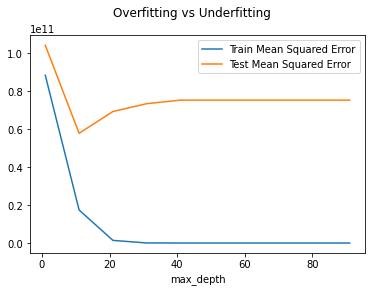

In [32]:
df.set_index("max_depth", inplace=True)
df["mse_train"].plot(label="Train Mean Squared Error")
df["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

# Random Forest 

In [33]:
# entrenamos el modelo RF base y conocemos su R2

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*rf_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 96.64
Precisión sobre los datos de test: 71.43


In [ ]:
# creamos los parametros para el hyper tunning
# Number of trees in random forest
est_list = [int(x) for x in np.linspace(start = 10, stop = 120, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
RF_grid = {'n_estimators': est_list,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(RF_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 22, 34, 46, 58, 71, 83, 95, 107, 120]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 22, 34, 46, 58, 71,
                                                         83, 95, 107, 120]},
                   random_state=42, verbose=2)

In [ ]:
# Encontramos el top 5 de los mejores modelos con los mejores parámetros 
all_results = pd.DataFrame(rf_random.cv_results_)
all_results.sort_values(by = "rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
32,3.977140,0.053242,0.216421,0.010712,46,5,1,sqrt,100,False,"{'n_estimators': 46, 'min_samples_split': 5, '...",0.756772,0.762546,0.755018,0.758112,0.003216,1
21,8.948440,0.015917,0.475354,0.069703,95,5,1,sqrt,70,False,"{'n_estimators': 95, 'min_samples_split': 5, '...",0.756065,0.767115,0.749196,0.757458,0.007382,2
24,7.360913,0.305711,0.370062,0.009915,83,5,1,sqrt,80,False,"{'n_estimators': 83, 'min_samples_split': 5, '...",0.753016,0.766590,0.751548,0.757052,0.006772,3
46,22.921996,0.110169,0.471384,0.011509,120,2,2,auto,90,True,"{'n_estimators': 120, 'min_samples_split': 2, ...",0.752902,0.763568,0.751700,0.756057,0.005334,4
67,15.845859,0.066250,0.315017,0.010540,83,2,2,auto,70,True,"{'n_estimators': 83, 'min_samples_split': 2, '...",0.754012,0.762890,0.749900,0.755601,0.005421,5


In [ ]:

# Perfomance del modelo
rf_base_model = RandomForestRegressor(random_state=42)
rf_base_model.fit(X_train, y_train)
rf_base_accuracy = evaluate(rf_base_model, X_test, y_test)

# Perfomance del modelo con randomizedsearchcv
rf_best_random = rf_random.best_estimator_
rf_random_accuracy = evaluate(rf_best_random, X_test, y_test)

print((100*(rf_random_accuracy-rf_base_accuracy)/rf_base_accuracy))

Model Perfomance
Aaverage Error: 120235.7242.degrees.
Accuracy = 76.34%.
Model Perfomance
Aaverage Error: 120320.6944.degrees.
Accuracy = 76.12%.
-0.2995927575606512


In [ ]:
# Hallamos el r2 para el mejor modelo (default)
pred_train = rf_base_model.predict(X_train)
print (r2_score(y_train, pred_train))

0.9664386420380268


# Gradient Boosting

In [ ]:
# Importamos la librería 
from sklearn.ensemble import GradientBoostingRegressor
# Generamos el modelo
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Hallamos el nivel de precision del model
pred_test_gb = gb_model.predict(X_test)
pred_train_gb = gb_model.predict(X_train)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*gb_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*gb_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 79.67
Precisión sobre los datos de test: 70.36


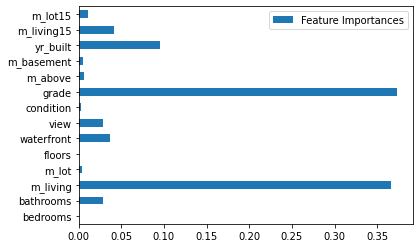

In [ ]:
# Conocemos las variables más importantes del modelo 
df_imp = pd.DataFrame(gb_model.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

In [ ]:
# Conocemos su r2 
pred_train = gb_model.predict(X_train)
print (r2_score(y_train, pred_train))

0.7967487462569671


# Ada Boost

In [ ]:
ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=2), random_state=0, n_estimators=100, learning_rate=0.8)
ada_model.fit(X_train, y_train)
pred_train = ada_model.predict(X_train)
pred_test = ada_model.predict(X_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*ada_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*ada_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 28.56
Precisión sobre los datos de test: 28.78


In [ ]:
errors_test = [mean_squared_error(y_test, y_pred) for y_pred in ada_model.staged_predict(X_test)]
errors_train = [mean_squared_error(y_train, y_pred) for y_pred in ada_model.staged_predict(X_train)]
errors_test[0:5]

[81557638677.14238,
 81557638677.14238,
 83920114076.75241,
 79551773811.49313,
 75504879815.85333]

In [ ]:
best_n_AD = np.argmin(errors_test)
best_n_AD

5

In [ ]:
best_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=2), random_state=0, n_estimators=best_n_AD, learning_rate=0.8)
best_model.fit(X_train, y_train)
pred_train = best_model.predict(X_train)
pred_test = best_model.predict(X_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*best_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*best_model.score(X_test, y_test)))


Precisión sobre los datos de entrenamiento: 56.19
Precisión sobre los datos de test: 50.06


In [ ]:
from sklearn.metrics import r2_score
r2_test = [r2_score(y_test, y_pred) for y_pred in ada_model.staged_predict(X_test)]
r2_train = [r2_score(y_train, y_pred) for y_pred in ada_model.staged_predict(X_train)]
r2_test[0:5]

[0.4605145365340927,
 0.4605145365340927,
 0.44488729233529,
 0.47378288213907704,
 0.5005521770604002]

In [ ]:
pred_train = best_model.predict(X_train)
print (r2_score(y_train, pred_train))

0.5619392031268589
